# Creating your project and comparing historical meteorological datasets

## Introduction

Notebook for the workflow **Snakefile_climate_historical**: 
1. extract climatic data for each climate source for the selected region and write to netcdf, 
2. plot annual gridded anomalies for temperature and precipitation for each climate source, 
3. sample point locations of precipitation and temperature at meteorological station observations (if available) and sample areal precipitation and temperature over subregions for each climate source, 
4. derive historical trends in precipitation and temperature for each climate source,
5. plot precipitation and temperature characteristics for each climate source,
6. plot region, elevation and meteorological stations (if available).

In [3]:
# Import some python libraries we will need to run this notebook
import os
import pandas as pd
from IPython import display
from IPython.display import Image, display

In [4]:
# A helper function
from subprocess import Popen, PIPE, STDOUT

from IPython.core.magic import register_line_magic


@register_line_magic
def runrealcmd(command):
    with Popen(
        command, stdout=PIPE, shell=True, stderr=STDOUT, bufsize=1, close_fds=True
    ) as process:
        for line in iter(process.stdout.readline, b""):
            print(line.rstrip().decode("utf-8"))

## Defining your project region and properties

First thing is to prepare all the options for your project, this is done using the configuration or settings file below

In [5]:
# Add here the path where you have installed the blueearth-cst tool
cst_path = r'c:\repos\blueearth_cst'
os.chdir(cst_path)

To extract data for your basin or region of interest, you will need to provide:

- for a basin to the sea, any point in the basin [x, y]
- for a subbasin (tributary or part of a basin) the location of the subbasin outlet [xout, yout]
- a bounding box [xmin, ymin, xmax, ymax]
- a geometry file of your region of interest (e.g., myregion.shp)

For more details on the exact syntax, please have a look at:
https://deltares.github.io/hydromt/stable/user_guide/model_region.html#hydrographic-region 

The coordinates should be in EPSG 4326.
For points, you can use Google Maps to locate your coordinates.
For bounding box or point coordinates, you can also copy-paste locations from this website: http://bboxfinder.com/

In [14]:
%%writefile ./config/my-project-settings.yml

########################################################################################
#################################### General settings ##################################

# Path to where the wflow model will be stored (include the project name)
project_dir: examples/myModel

# hydromt "region" for building the model, coordinates are in EPSG 4326
# for more info on how to fill this, please check the hydromt documentation: 
# https://deltares.github.io/hydromt/stable/user_guide/model_region.html#hydrographic-region 
# For wflow please use either 'basin' or 'subbasin' keywords
model_region: "{'subbasin': [12.3758, 46.4076], 'uparea': 70}"

# Path to the data catalog to use (can be different for Linux/Windows/data stored on P drive or other)
# NB: should in order of priority! 
data_sources: 
  - artifact_data
  - tests/data/tests_data_catalog.yml

# Info on the historical climate data is used in the historic model run + reference data for the weather generator
# Time horizon of the historical period
starttime: "2000-01-01T00:00:00"
endtime: "2010-12-31T00:00:00"

# Historical gridded climate data sources (name as available in the data_sources catalog file). 
clim_historical: 
  - era5
  - chirps_global

#colors to use for plotting (same order as provided in clim_historical)
clim_historical_colors:
  - blue
  - green

########################################################################################
######################### Analysis of historical climate data ##########################

# Buffer in km to apply to the region for the climate analysis
region_buffer: 10
# Hydrography dataset to use to derive region from (sub)basin
hydrography_fn: merit_hydro_ihu
# River geometry dataset to add to plots
river_geom_fn: river_atlas

# Additional sub-basins or sub-regions to include in the analysis
climate_subregions: "tests/test_project/hydrology_model/staticgeoms/subcatch_discharge-locations-grdc.geojson"

# If available, please put here the path to the available climate observation stations locations files
# csv file containing four columns: station_ID, name, x, y
climate_locations: "tests/data/observations/climate-locations-eca.csv"
# Path to the file with observed precipitation timeseries per station 
climate_locations_timeseries: "tests/data/observations/observations-climate-eca.csv" 

# Thresholds for the climate analysis
climate_thresholds:
  precip:
    peak: 40 # Precipitation peak threshold in mm/day
    dry: 0.2 # Precipitation daily mean dry threshold in mm/day
  temp:
    heat: 25 # Heat daily mean temperature threshold in degrees Celsius

# Plotting options
historical_climate_plots:
  basin_map:
    legend_loc: "lower right" # legend location in the basin map plot
  climate_per_location:
    max_nan_per_year: 60 # maximum number of nan per year in the observed data to be plotted
    max_nan_per_month: 5 # maximum number of nan per month in the observed data to be plotted
  timeseries_trends:
    split_year: 2005 # Split year for the timeseries trends
  climate_per_year: # plot options for the gridded climate data per year
    year_per_line: 6
    fontsize: 6
  mean_precipitation: # plot options for the gridded mean precipitation
    add_rivers: true
    fontsize: 8

Overwriting ./config/my-project-settings.yml


To evaluate global or regional precipitation data using observed data, the user may provide timeseries and locations of observed precipitation. 
The locations of the stations are provided in a csv file, in *climate_locations* of the config file. The csv file should contain 4 columns with headers: 
- id
- name
- x
- y
- elevtn

Elevation (elevtn) of the station can (optionally) also be provided.

An example is shown below:

In [5]:
pd.read_csv("tests/data/observations/climate-locations-eca.csv")

id     name        x        y  elevtn
0  24431  SILLIAN  12.4231  46.7458    1081

The timeseries containing the actual data is also provided in a csv file (*climate_locations_timeseries*). 

The format should include a column with the time dimension and columns with precipitation timeseries (mm/d) for each *id* of the station locations (with a `,` delimiter). This is shown below:   

In [6]:
pd.read_csv("tests/data/observations/observations-climate-eca.csv", parse_dates=True, index_col=0, header=0, sep=",")

24431
time             
2000-01-01    0.0
2000-01-02    0.0
2000-01-03    0.0
2000-01-04    0.0
2000-01-05    0.0
...           ...
2010-12-27    0.0
2010-12-28    0.0
2010-12-29    0.0
2010-12-30    0.0
2010-12-31    0.0

[4018 rows x 1 columns]

## Running the historical climate workflow

The first line is to create an image of our workflow with snakemake to verify that all our settings are correctly accounted for.

In [7]:
! snakemake -s snakemake/Snakefile_climate_historical.smk --configfile config/my-project-settings.yml  --dag | dot -Tpng > dag_historical_climate.png

Building DAG of jobs...


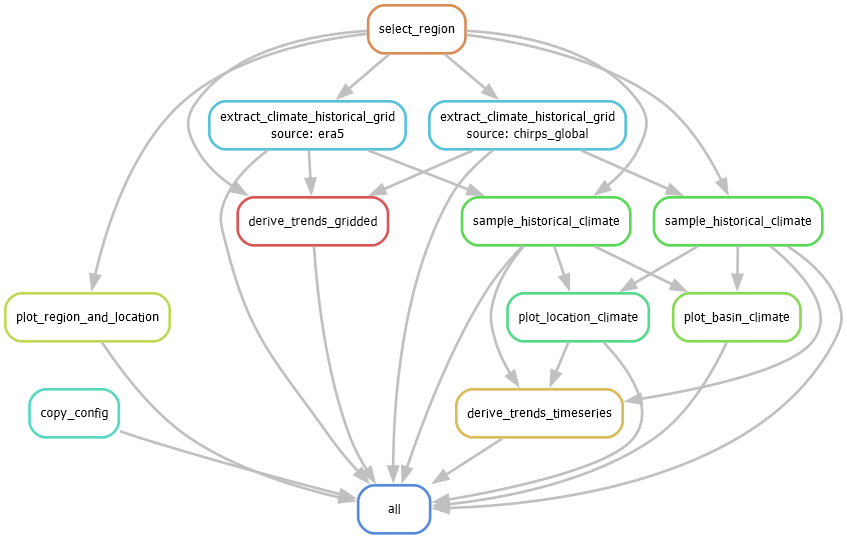

In [8]:
display(Image("./dag_historical_climate.png"))

Let's have a closer look at this diagram, which shows the subsequent rules of the snakemake workflow:

1. `select region`: this rule selects the region of interest based on the arguments provided by the users in *model_region* of the config file and considering a *region_buffer* around the area of interest. A geojson file is created.    
2. `extract_climate_historical_grid`: here the data for each of the climate sources is downloaded from the global/regional extent to the clipped extent of the region of interest. 
3. `derive_trends_gridded`: this rule plots gridded annual anomalies of precipitation and temperature based on the extracted climate data for each climate source.
4. `sample_historical_climate`: precipition and temperature timeseries are sampled at the locations of meteorological stations (if available and provided in *climate_locations* of the config file) and timeseries of mean precipitation and temperature over subregions (which can be provided in *climate_subregions*).  
5. `plot_location_climate`: in this step, several plots for temperature and precipitation are made to compare the different climate sources with timeseries of observed precipitation (if provided in *climate_locations_timeseries* of the config file).
6. `plot_basin_climate`: the same plots as in the previous step are made, but now for the mean areal precipitation and temperature averaged over the subregions. This is useful to evaluate differences in precipitation over a large area instead of a single cell. 
7. `derive_trends_timeseries`: trends in precipitation and temperature at the locations of the meteorological stations are evaluated over the historical period for the different climate sources.
8. `plot_region_and_location`: saves a map of the basin, elevation, subregions, meteorological station locations and rivers.
9. `copy_config`: all configuration files are saved to make the workflow reproducible. 


Now we will unlock your directory in order to save the future results of the workflow. This step is most of the time not necessary.

In [9]:
! snakemake --unlock -s snakemake/Snakefile_climate_historical.smk --configfile config/my-project-settings.yml

Building DAG of jobs...
Unlocked working directory.


Snakemake also allows us to run a so-called *dryrun*, which will not actually run the workflow, but just print an overview of the rules that will be executed.

In [2]:
! snakemake all -c 1 -s snakemake/Snakefile_climate_historical.smk --configfile config/my-project-settings.yml --dryrun

In the following, we will actually run the snakemake workflow for the historical hydrology:

In [29]:
%runrealcmd snakemake all -c 1 -s snakemake/Snakefile_climate_historical.smk --configfile config/my-project-settings.yml

## Results

First check that snake did run everything.

The diagram will show dotted lines when a rule has already been performed. 

In [16]:
! snakemake -s snakemake/Snakefile_climate_historical.smk --configfile config/my-project-settings.yml  --dag | dot -Tpng > dag_historical_climate.png

Building DAG of jobs...


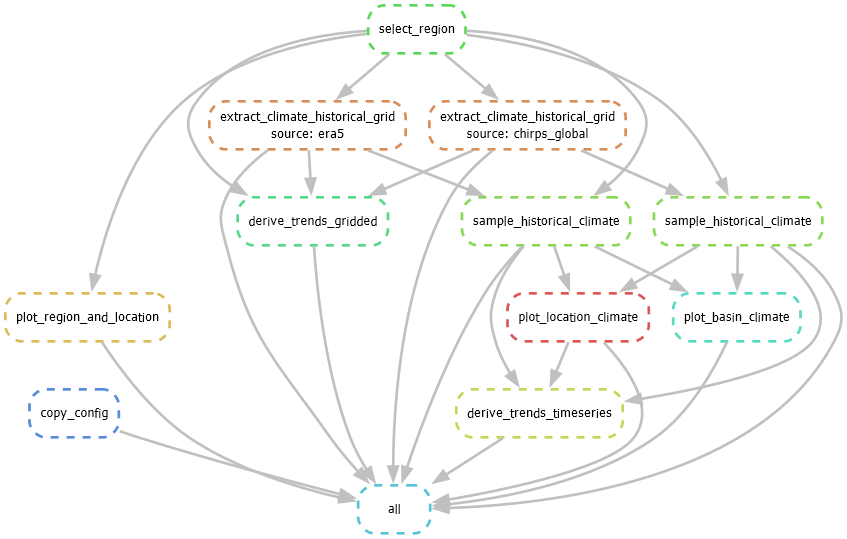

In [17]:
display(Image("./dag_historical_climate.png"))

Let's see which files where created in our output folder. Let's see which files where created in our output folder. The location of the output folder is defined in the config file under *project_dir*. The results of this workflow are stored in the directory `climate_historical`. The plots are saved in `examples/myModel/plots/climate_historical`.

In [6]:
root = "examples/myModel/climate_historical"
for path, _, files in os.walk(root):
    print(path)
    for name in files:
        if name.endswith(".xml"):
            continue
        print(f" - {name}")

examples/myModel/climate_historical
examples/myModel/climate_historical\raw_data
 - extract_chirps_global.nc
 - extract_era5.nc
examples/myModel/climate_historical\statistics
 - basin_chirps_global.nc
 - basin_era5.nc
 - point_chirps_global.nc
 - point_era5.nc
 - point_observed.nc
examples/myModel/climate_historical\wflow_data
 - inmaps_historical_chirps_global.nc
 - inmaps_historical_era5.nc


The region we have selected in this example notebook is the Piave, a small basin in Italy. The ECA climate dataset includes one station just outside the basin at SILLIAN. The location of the meteorological station, the elevation of the basin, the river network, the subregion (based on the upstream area of the location of a discharge station) are shown in the figure below. 

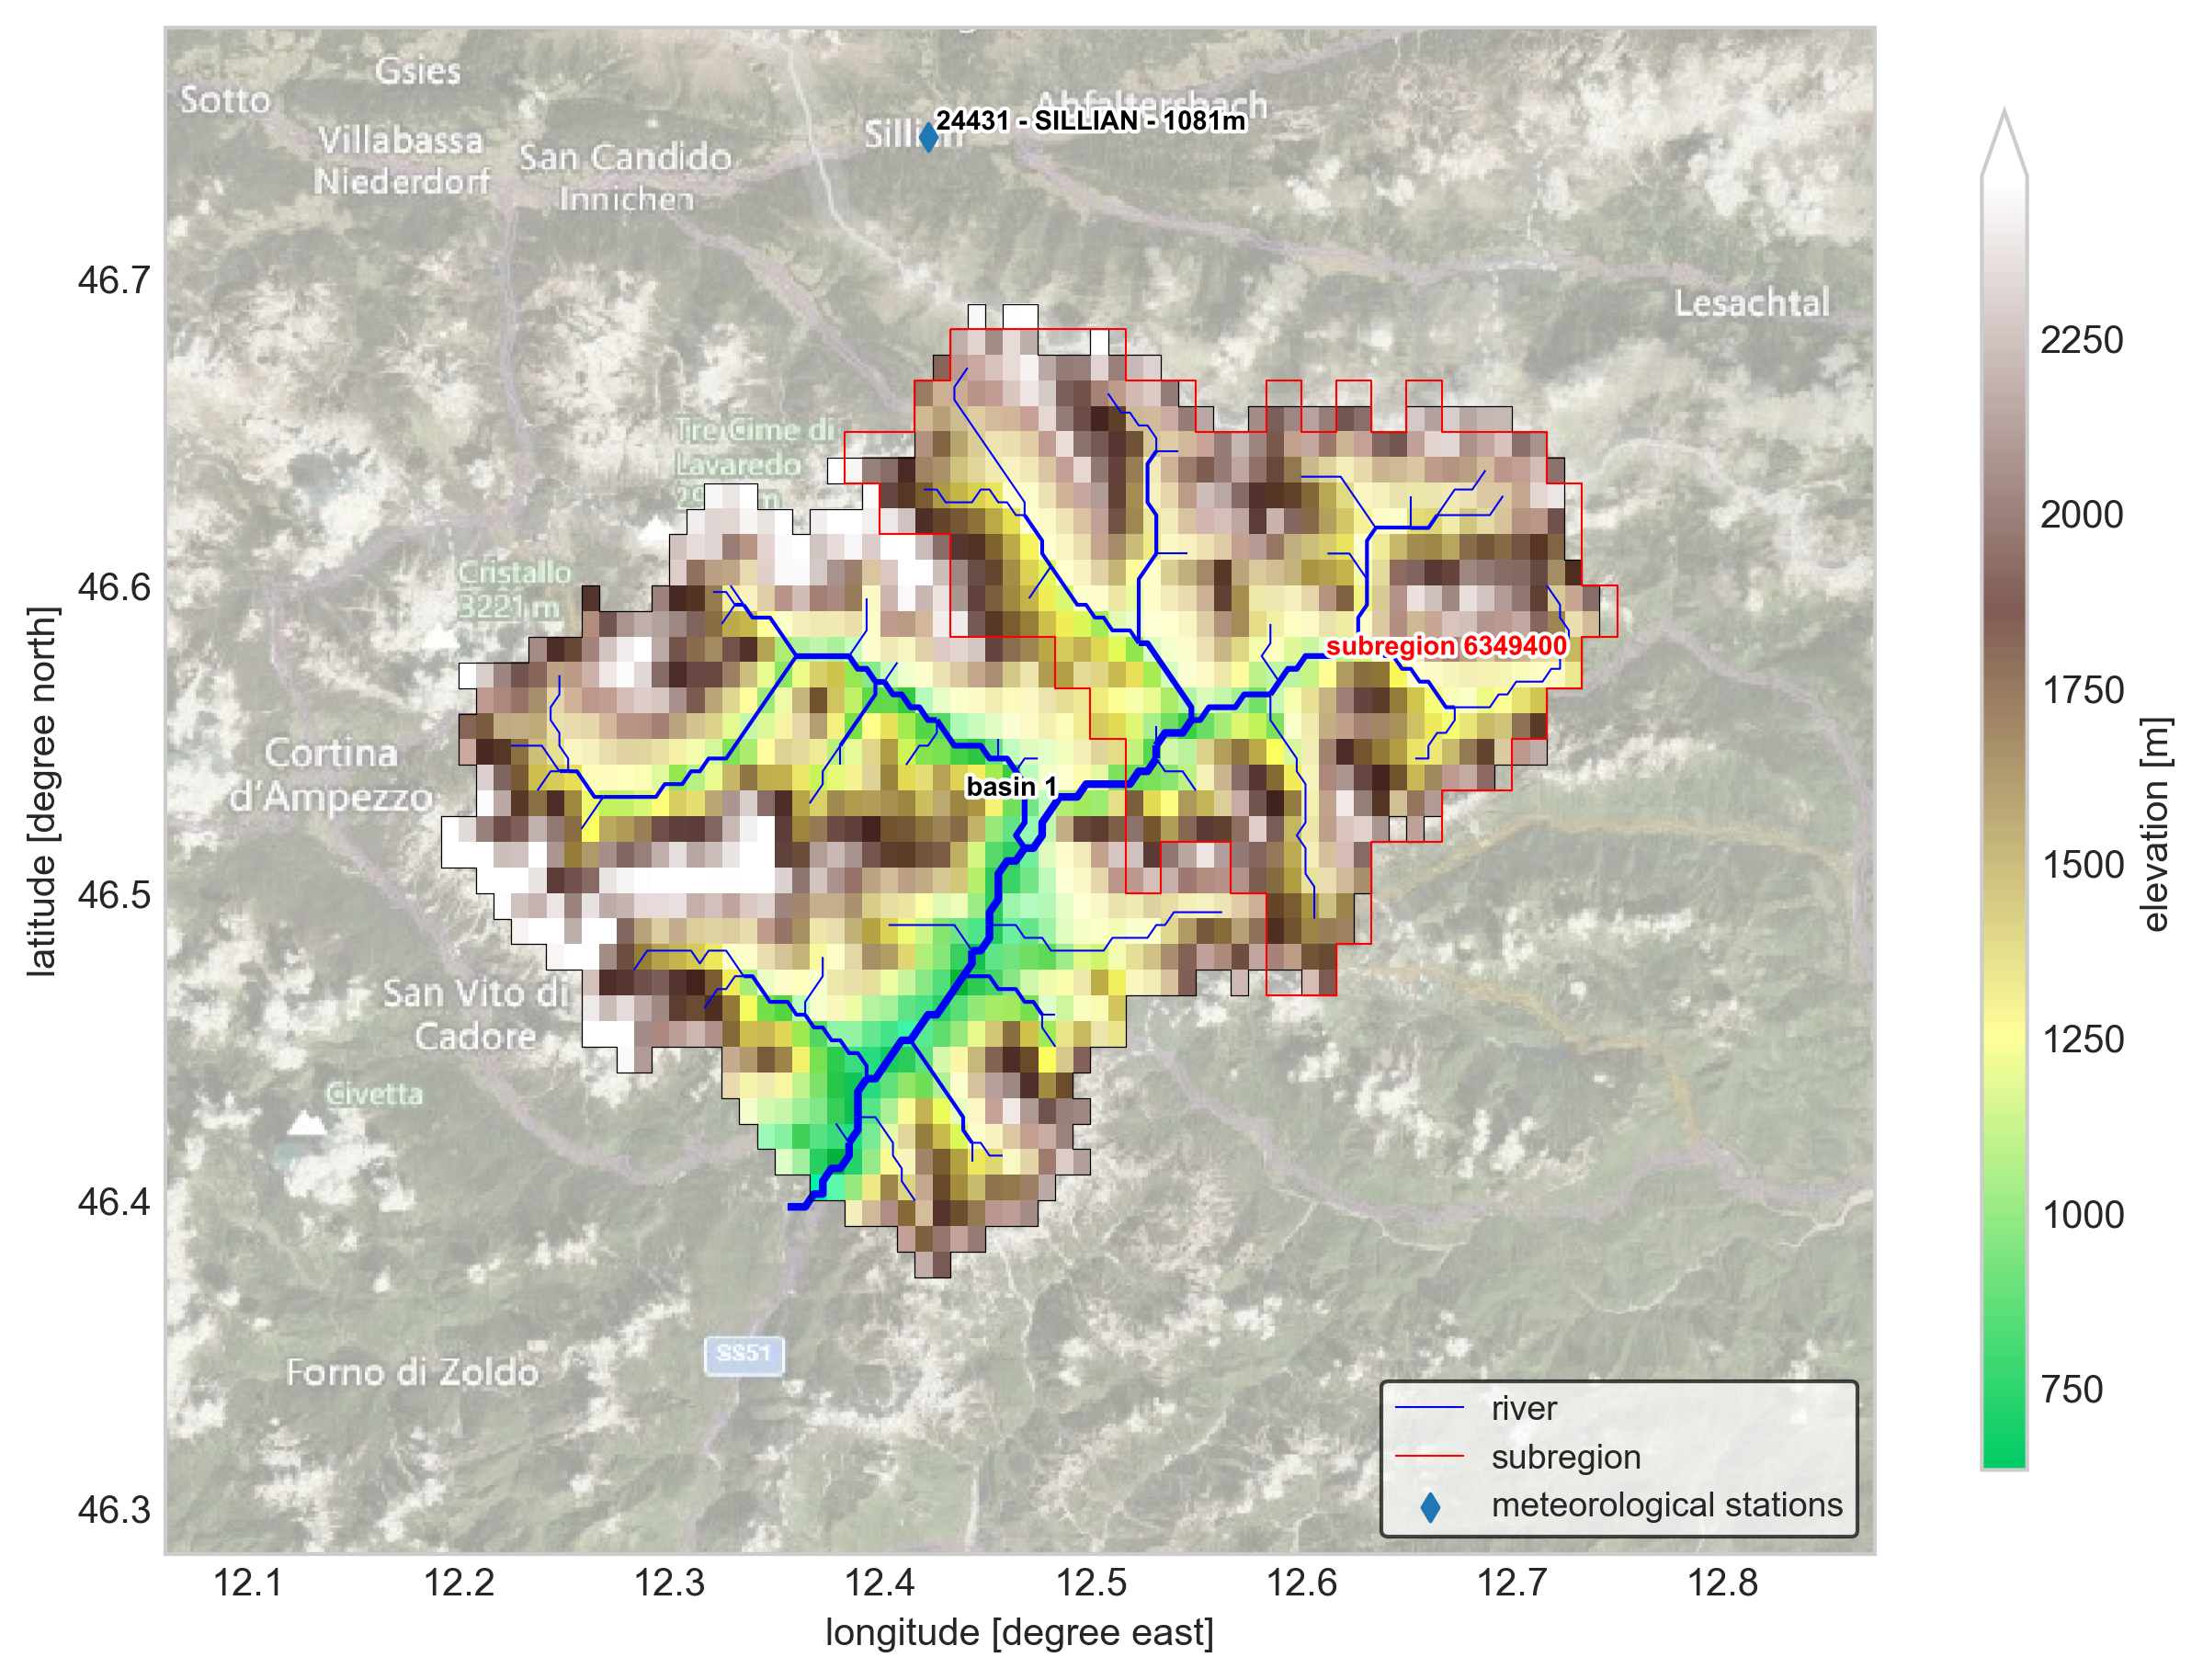

In [19]:
display(Image("./examples/myModel/plots/climate_historical/region_plot.png"))

The extracted netcdf files of the climate data for each source are located in the folder `examples/myModel/climate_historical\raw_data`, as shown below:

In [20]:
root = "examples/myModel/climate_historical/raw_data"
for path, _, files in os.walk(root):
    print(path)
    for name in files:
        if name.endswith(".xml"):
            continue
        print(f" - {name}")

examples/myModel/climate_historical/raw_data
 - extract_chirps_global.nc
 - extract_era5.nc


We first compare the spatial patterns of annual precipitation for the two selected climate sources (ERA5 and CHIRPS_global). As shown in the Figure below, there is a substantial difference between both datasets for the Piave basin. 

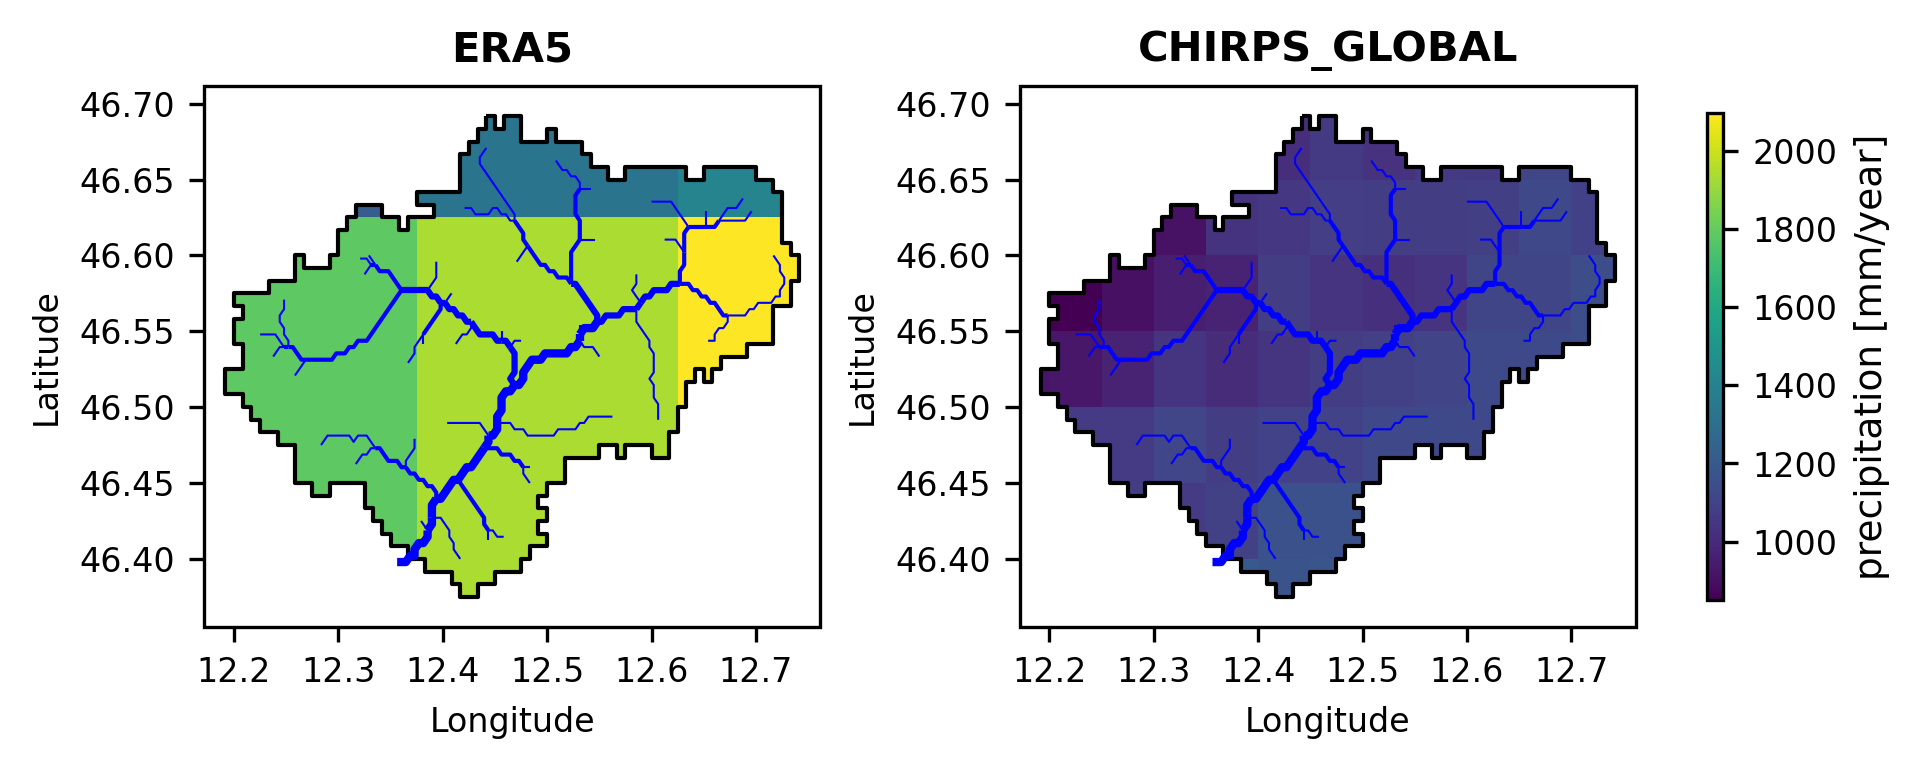

In [21]:
display(Image("./examples/myModel/plots/climate_historical/grid/mean_annual_precipitation.png", width=600))

In the next notebook on historical hydrology (`docs/notebooks/Historical hydrology.ipynb`), we will see that these differences in precipitation lead to an overestimation of streamflow when using the ERA5 dataset as input, while streamflow is underestimated when CHIRPS_global dataset is used as input. 

Anomalies in annual precipitation rates, showing years with above normal or below normal precipitation, are shown in the Figure below. Similar figures are made in this workflow for each of the climate sources and also for temperature. 

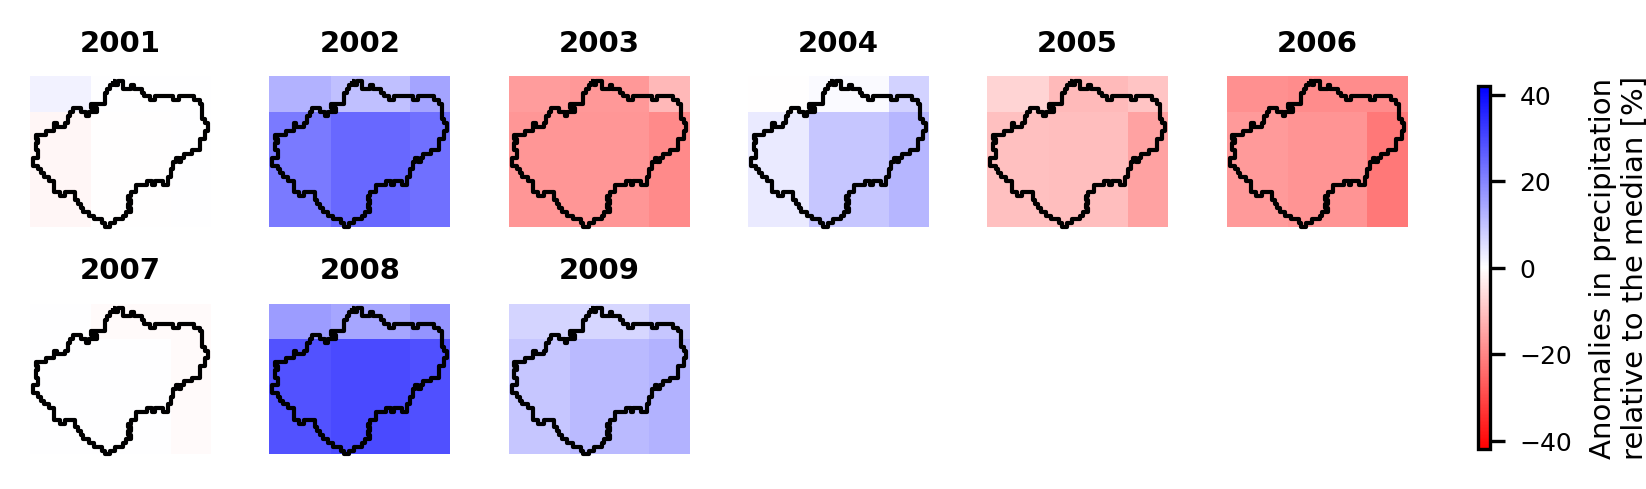

In [22]:
display(Image("./examples/myModel/plots/climate_historical/trends/gridded_anomalies_precip_era5.png"))

Trends in precipitation at the locations of the climate stations for each of the climate sources are also plotted in this workflow. In the config file, it is possible to provide a year (*split_year*) to split the trend line in two periods. 

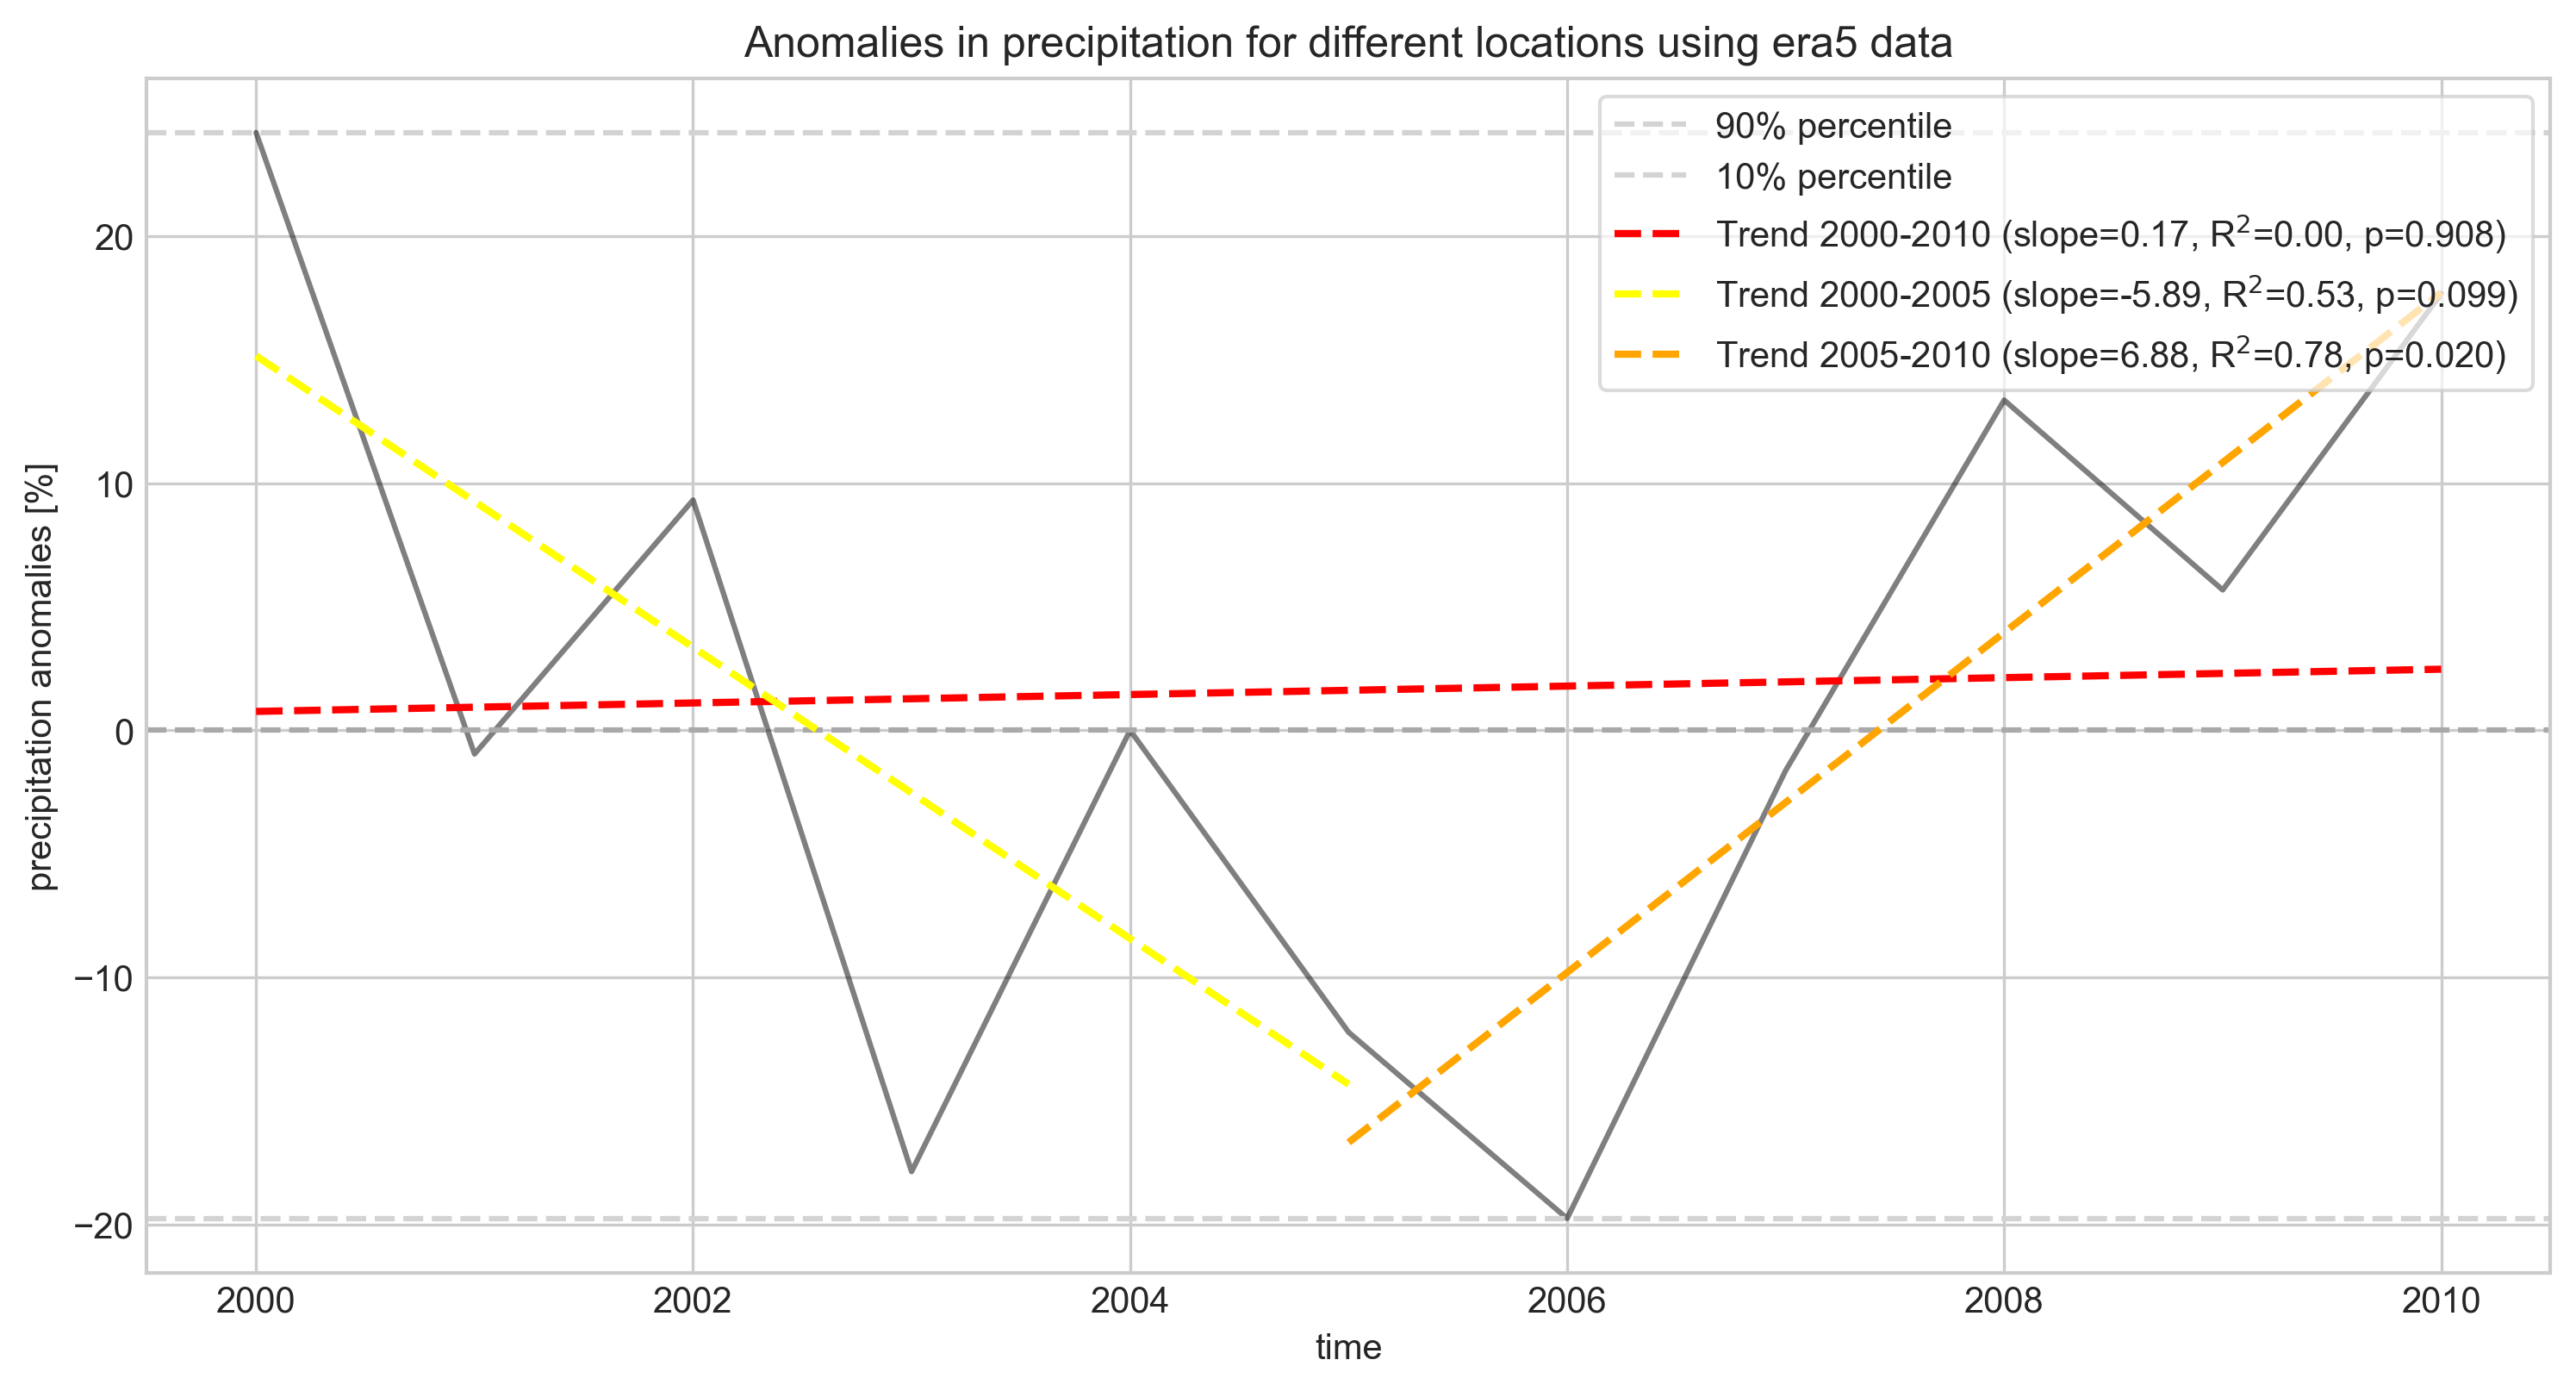

In [23]:
display(Image("./examples/myModel/plots/climate_historical/trends/timeseries_anomalies_precip_era5.png", width=600))

The workflow creates plots to show precipitation characteristics at the location of the stations and averaged over the subregions. Observed station data is added to these plots when available. 

For each subregion or location of a precipitation station and for each of the climate sources, the following plots are made:
- annual precipitation,
- cumulative precipitation,
- mean monthly precipitation,
- daily precipitation of the wettest year,
- daily precipitation of the driest year. 

This allows the user to evaluate precipitation volumes, dynamics and seasonality at various temporal scales between different climate sources. 


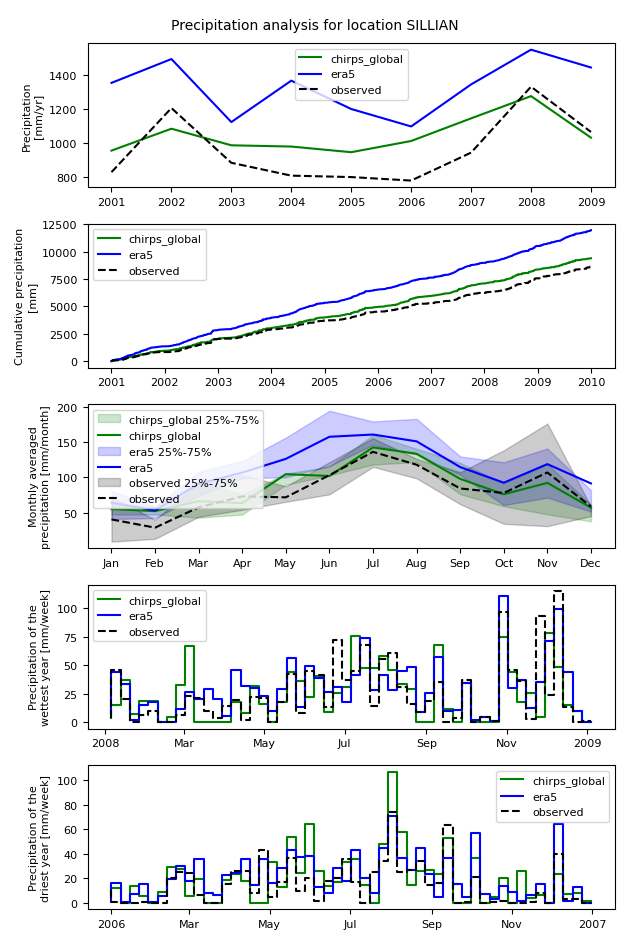

In [24]:
display(Image("./examples/myModel/plots/climate_historical/point/precipitation_SILLIAN.png"))

In addition, plots are made of:
- the Standardized Precipitation Index (SPI)
- the number of events per year with precipitation higher than a defined threshold in the config file (*climate_thresholds.precip.peak*)
- the number of dry days per year (*climate_thresholds.precip.dry*)

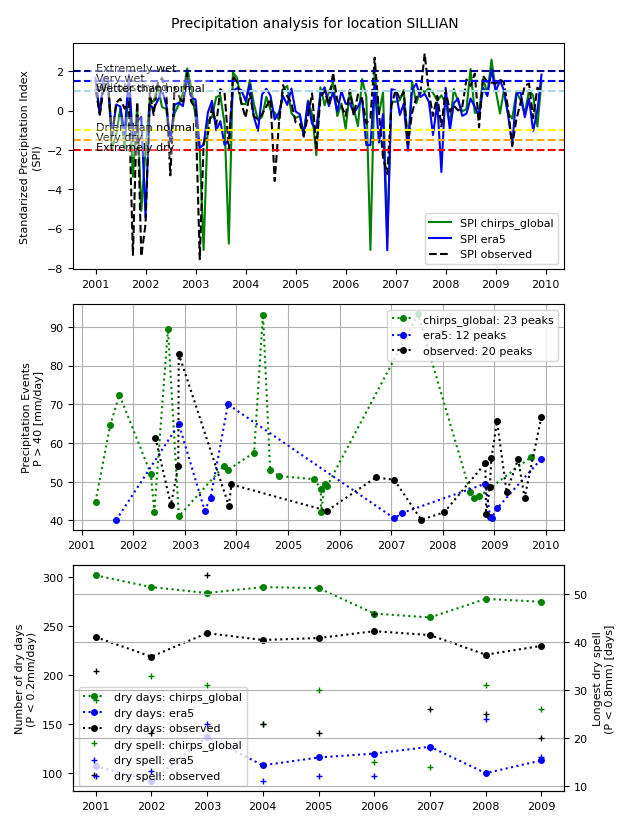

In [25]:
display(Image("./examples/myModel/plots/climate_historical/point/precipitation_extra_SILLIAN.png"))

In the above example, we see a relatively good agreement between CHIRPS data and observed precipitation at the station of SILLIAN, while ERA5 overestimates observed precipitation. 

In the plot below, the difference in mean annual precipitation averaged over the subregions is shown, where:
- regions_1 represents the area upstream of the outlet of the basin
- subregion_6349400 is the area upstream of the hydrological gauges (as provided in *climate_subregions* of the config file).

Interestingly, precipitation in ERA5 over the region is almost twice as high as precipitation in CHIRPS. 

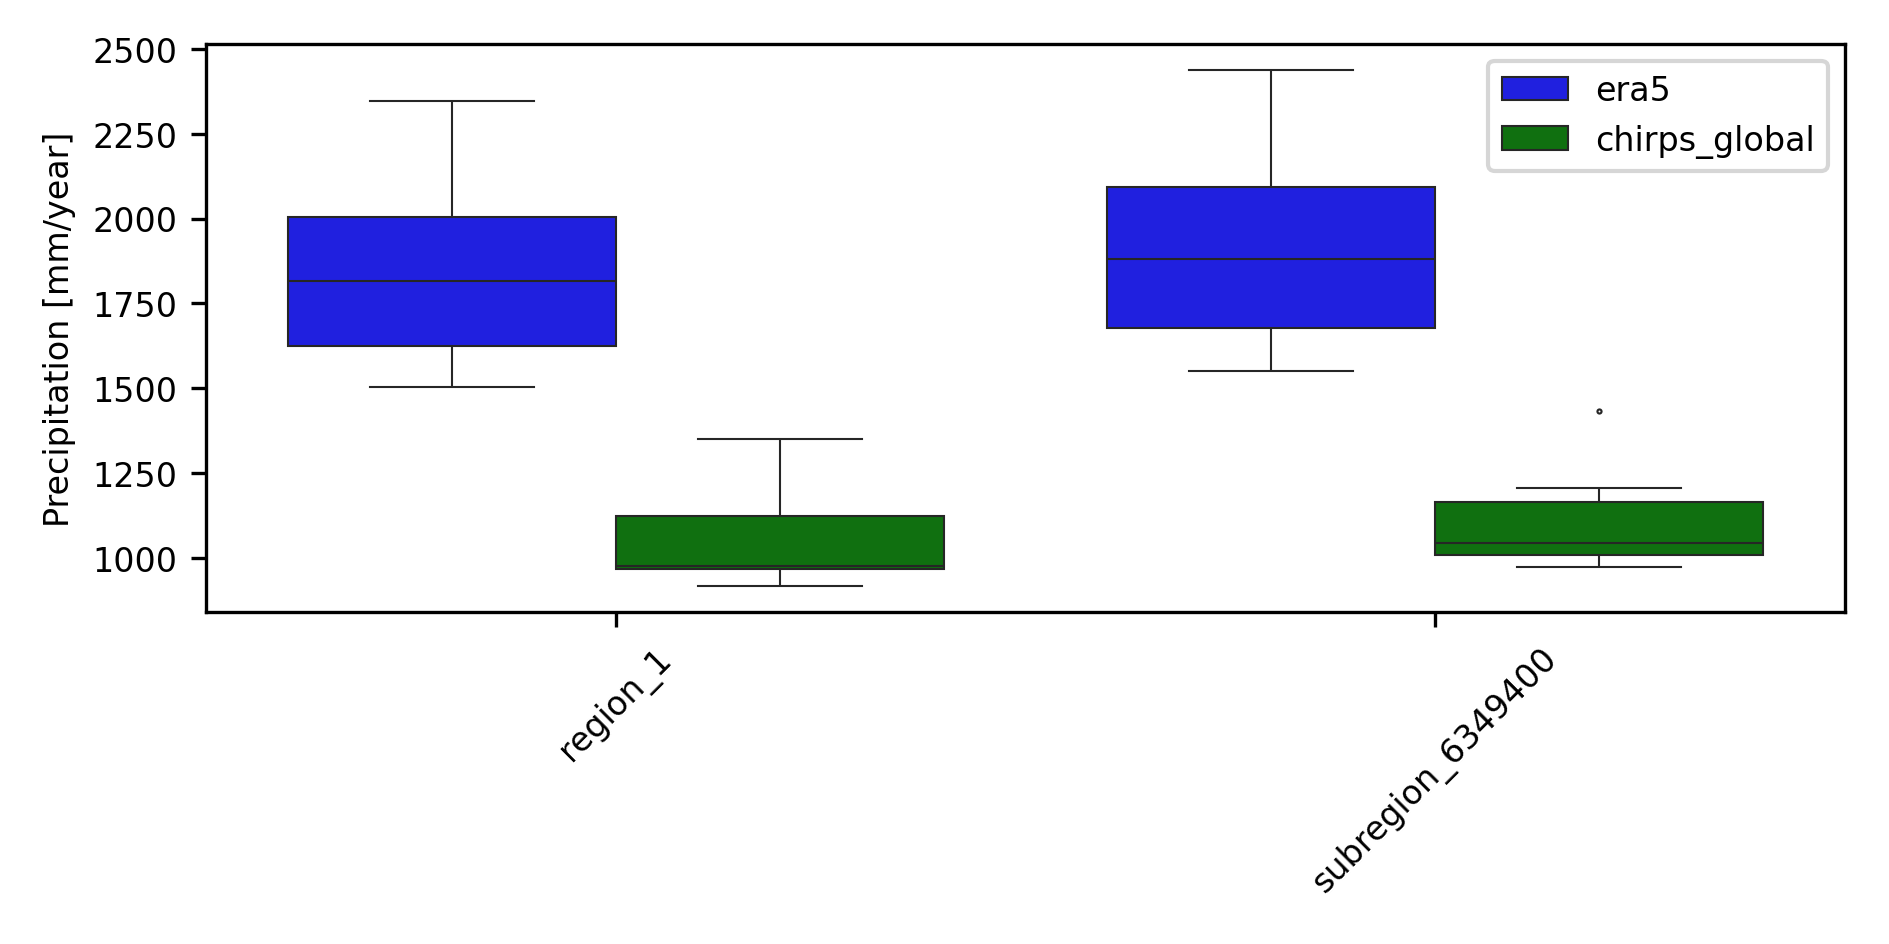

In [26]:
display(Image("./examples/myModel/plots/climate_historical/region/precipitation_boxplot.png", width=600))

Besides the precipitation analysis, we are also able to compare various sources of temperature data, as shown in the figure below. The following subplots are made for the evaluation of temperature data:
- time series of monthly temperature 
- mean monthly temperature regime 
- number of frost days 
- number of days with temperature above a certain threshold, which can be defined in the config file (*climate_thresholds.temp.heat*).

Again, this is done for at the location of the meteorological stations and for the subregions. In the example below, we only have ERA5 temperature as CHIRPS is a dataset providing only precipitation data. 

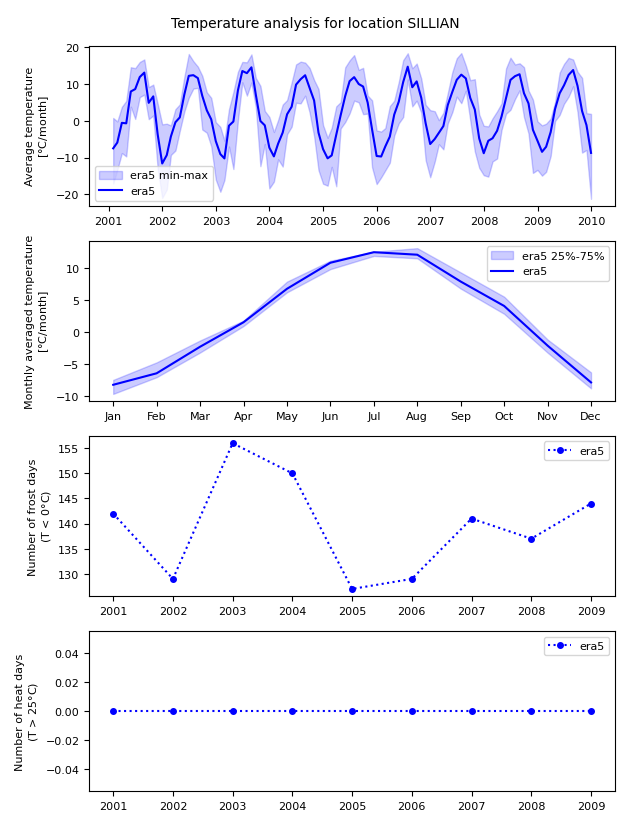

In [27]:
display(Image("./examples/myModel/plots/climate_historical/point/temperature_SILLIAN.png"))